# Load packages and set global variables

In [1]:
import numpy as np
import pandas
import time
import seaborn as sns
import sys
import scanpy.api as sc
import diffxpy.api as de

sc.settings.verbosity = 3 # amount of output
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, scanpy=True)
print(sys.version)

/Users/david.fischer/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


scanpy==1.3.1 anndata==0.6.10 numpy==1.14.5 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


/Users/david.fischer/miniconda3/lib/python3.6/site-packages/igraph/configuration.py:288: DeprecationWarning: The SafeConfigParser class has been renamed to ConfigParser in Python 3.2. This alias will be removed in future versions. Use ConfigParser directly instead.
  self._config = SafeConfigParser()
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/igraph/configuration.py:288: DeprecationWarning: The SafeConfigParser class has been renamed to ConfigParser in Python 3.2. This alias will be removed in future versions. Use ConfigParser directly instead.
  self._config = SafeConfigParser()


## Set R environment

In [49]:
import rpy2
import warnings
from rpy2.robjects.packages import importr
from rpy2.rinterface import RRuntimeWarning
from rpy2.robjects import pandas2ri

%load_ext rpy2.ipython
print(rpy2.__version__)

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
2.9.1


Install limma if not already installed:

In [53]:
if False:
    from rpy2.robjects.packages import importr
    base = importr('base')
    base.source("http://www.bioconductor.org/biocLite.R")
    biocinstaller = importr("BiocInstaller")
    biocinstaller.biocLite("limma")
    # a prompt opens, this corresponds to "Update all/some/none? [a/s/n]:"

a


'limma'


Install MAST if not already installed:

In [ ]:
if False:
    from rpy2.robjects.packages import importr
    base = importr('base')
    base.source("http://www.bioconductor.org/biocLite.R")
    biocinstaller = importr("BiocInstaller")
    biocinstaller.biocLite("MAST")
    # a prompt opens, this corresponds to "Update all/some/none? [a/s/n]:"

## Set global variables

Set platform this notebook is executed on:

In [2]:
platform = ['int_server', 'laptop'][1]

Set directory in which .h5 files are:

In [3]:
if platform=='int_server':
    dir_in = '/storage/groups/ml01/workspace/david.fischer/diffxpy/datasets/ilc/GSE102299_RAW/'
    dir_out = '/storage/groups/ml01/workspace/david.fischer/diffxpy/scanpy_out/ilc/'
    sc.settings.figdir = '/storage/groups/ml01/workspace/david.fischer/diffxpy/figures/ilc'
elif platform=='laptop':
    dir_in = None
    dir_out = '/Users/david.fischer/phd/data/BatchSGD/adata/ilc/'
    sc.settings.figdir = '/Users/david.fischer/phd/data/BatchSGD/figures/raw/ilc'
else:
    raise ValueError('platform not recognized')

In [4]:
bool_recompute = False

# Load data

In [5]:
mtx_files = [
    'GSM2733478_PBS_Rep1.matrix.mtx',
    'GSM2733479_PBS_Rep2.matrix.mtx',
    'GSM2733480_IL25_Rep1.matrix.mtx',
    'GSM2733481_IL25_Rep2.matrix.mtx',
    'GSM2733482_IL33_Rep1.matrix.mtx',
    'GSM2733483_IL33_Rep2.matrix.mtx',
    'GSM2733484_NMU_Rep1.matrix.mtx',
    'GSM2733485_NMU_Rep2.matrix.mtx',
    'GSM2733486_NMU_IL25_Rep1.matrix.mtx',
    'GSM2733487_NMU_IL25_Rep2.matrix.mtx',
    'GSM2733488_WT_PBS_Rep1.matrix.mtx',
    'GSM2733489_WT_PBS_Rep2.matrix.mtx',
    'GSM2733490_WT_HDM_Rep1.matrix.mtx',
    'GSM2733491_WT_HDM_Rep2.matrix.mtx',
    'GSM2733492_KO_Nmur1_PBS_Rep1.matrix.mtx',
    'GSM2733493_KO_Nmur1_PBS_Rep2.matrix.mtx',
    'GSM2733494_KO_Nmur1_HDM_Rep1.matrix.mtx',
    'GSM2733495_KO_Nmur1_HDM_Rep2.matrix.mtx'
    ]

In [6]:
bc_files = [
    'GSM2733478_PBS_Rep1.barcodes.tsv',
    'GSM2733479_PBS_Rep2.barcodes.tsv',
    'GSM2733480_IL25_Rep1.barcodes.tsv',
    'GSM2733481_IL25_Rep2.barcodes.tsv',
    'GSM2733482_IL33_Rep1.barcodes.tsv',
    'GSM2733483_IL33_Rep2.barcodes.tsv',
    'GSM2733484_NMU_Rep1.barcodes.tsv',
    'GSM2733485_NMU_Rep2.barcodes.tsv',
    'GSM2733486_NMU_IL25_Rep1.barcodes.tsv',
    'GSM2733487_NMU_IL25_Rep2.barcodes.tsv',
    'GSM2733488_WT_PBS_Rep1.barcodes.tsv',
    'GSM2733489_WT_PBS_Rep2.barcodes.tsv',
    'GSM2733490_WT_HDM_Rep1.barcodes.tsv',
    'GSM2733491_WT_HDM_Rep2.barcodes.tsv',
    'GSM2733492_KO_Nmur1_PBS_Rep1.barcodes.tsv',
    'GSM2733493_KO_Nmur1_PBS_Rep2.barcodes.tsv',
    'GSM2733494_KO_Nmur1_HDM_Rep1.barcodes.tsv',
    'GSM2733495_KO_Nmur1_HDM_Rep2.barcodes.tsv'
    ]

In [7]:
sample_ids = ['_'.join(x.split('.')[0].split('_')[1:]) for x in mtx_files]

In [8]:
if bool_recompute==True:
    adatas = []
    for i,fn in enumerate(mtx_files):
        adatas.append(sc.read_mtx(dir_in+fn).transpose())
        adatas[i].obs_names = np.genfromtxt(fname=dir_in+bc_files[i], dtype=str)
    adata = adatas[0].concatenate(
        adatas[1:], 
        join='outer', 
        batch_key='sample', 
        batch_categories=sample_ids, 
        index_unique='_'
    )
    adata.obs['n_counts'] = np.sum(adata.X, axis=1)
    adata.obs['treatment'] = [x.split('_Rep')[0] for x in adata.obs['sample'].values]
    adata.obs['study'] = ['stimulation' if x.split('_')[0] not in ['WT', 'KO'] else 'genotype' 
                          for x in adata.obs['sample'].values]
    adata_stim = adata[np.where(adata.obs['study'].values=='stimulation')[0],:].copy()
    adata_geno = adata[np.where(adata.obs['study'].values=='genotype')[0],:].copy()
    del(adata)

Show distribution of counts over cells:

In [9]:
if bool_recompute==True:
    sns.distplot(np.log(adata_stim.obs['n_counts'].values)/np.log(10), kde=False)

In [10]:
if bool_recompute==True:
    sns.distplot(np.log(adata_geno.obs['n_counts'].values)/np.log(10), kde=False)

# Process data

## Stimulation study

In [11]:
if bool_recompute==True:
    print(str(adata_stim.X.shape[0])+" cells before filtering.")
    sc.pp.filter_cells(adata_stim, min_counts=500)
    print(str(adata_stim.X.shape[0])+" cells after filtering.")
    sc.pp.filter_genes(adata_stim, min_counts=1000)
    sc.pp.normalize_per_cell(adata_stim)
    sc.pp.pca(adata_stim, zero_center=False, svd_solver='arpack')
    sc.pp.neighbors(adata_stim, n_neighbors=500)
    sc.tl.umap(adata_stim)
    sc.tl.tsne(adata_stim)
    sc.tl.louvain(adata_stim)
    sc.write(adata=adata_stim, filename=dir_out+"adata_stim_ilc.h5ad")
else:
    adata_stim = sc.read(dir_out+"adata_stim_ilc.h5ad")

saving figure to file /Users/david.fischer/phd/data/BatchSGD/figures/raw/ilc/umap_stim_treatment.pdf


KeyboardInterrupt: 

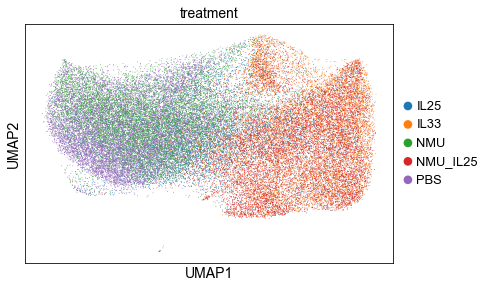

In [12]:
sc.pl.umap(adata_stim, color=['treatment'], save='_stim_treatment.pdf')
sc.pl.umap(adata_stim, color=['sample'], save='_stim_sample.pdf')
sc.pl.umap(adata_stim, color=['louvain'], save='_stim_louvain.pdf')
sc.pl.umap(adata_stim, color=['n_counts'], save='_stim_n_counts.pdf')

In [ ]:
sc.pl.tsne(adata_stim, color=['treatment'], save='_stim_treatment.pdf')
sc.pl.tsne(adata_stim, color=['sample'], save='_stim_sample.pdf')
sc.pl.tsne(adata_stim, color=['louvain'], save='_stim_louvain.pdf')
sc.pl.tsne(adata_stim, color=['n_counts'], save='_stim_n_counts.pdf')

## Genotype study

In [12]:
if bool_recompute==True:
    print(str(adata_geno.X.shape[0])+" cells before filtering.")
    sc.pp.filter_cells(adata_geno, min_counts=500)
    print(str(adata_geno.X.shape[0])+" cells after filtering.")
    sc.pp.filter_genes(adata_geno, min_counts=1000)
    sc.pp.normalize_per_cell(adata_geno)
    sc.pp.pca(adata_geno, zero_center=False, svd_solver='arpack')
    sc.pp.neighbors(adata_geno, n_neighbors=500)
    sc.tl.umap(adata_geno)
    sc.tl.tsne(adata_geno)
    sc.tl.louvain(adata_geno)
    sc.write(adata=adata_geno, filename=dir_out+"adata_geno_ilc.h5ad")
else:
    adata_geno = sc.read(dir_out+"adata_geno_ilc.h5ad")

In [ ]:
sc.pl.umap(adata_geno, color=['treatment'], save='_geno_treatment.pdf')
sc.pl.umap(adata_geno, color=['sample'], save='_geno_sample.pdf')
sc.pl.umap(adata_geno, color=['louvain'], save='_geno_louvain.pdf')
sc.pl.umap(adata_geno, color=['n_counts'], save='_geno_n_counts.pdf')

In [ ]:
sc.pl.tsne(adata_geno, color=['treatment'], save='_geno_treatment.pdf')
sc.pl.tsne(adata_geno, color=['sample'], save='_geno_sample.pdf')
sc.pl.tsne(adata_geno, color=['louvain'], save='_geno_louvain.pdf')
sc.pl.tsne(adata_geno, color=['n_counts'], save='_geno_n_counts.pdf')

# Differential expression analysis

In [13]:
adata_stim.obs['rep'] = [x.split('_')[-1] for x in adata_stim.obs['sample'].values]

Redefine the replicate naming so that the factor ordering changes. We need this for the replicate models later.

In [14]:
adata_stim.obs['rep_alternative'] = adata_stim.obs['rep'].values
adata_stim[adata_stim.obs['rep'].values=="Rep1",:].obs['rep_alternative'] = "Rep3"

## By condition

We perform the condition-wise test on a subset of the condition to ease interpretation below.

In [15]:
adata_stim_pbs_nmu = adata_stim[np.where([x in ['PBS', 'NMU'] 
                                          for x in adata_stim.obs['treatment'].values])[0],:].copy()

### Basic treatment tests

#### T-test

In [ ]:
t_tt_0 = time.time()
det_tt = de.test.t_test(
    adata_stim_pbs_nmu, 
    grouping="treatment"
)
t_tt_1 = time.time()
t_tt = t_tt_1-t_tt_0

#### limma

In [59]:
r_adata_stim_pbs_nmu_X = adata_stim_pbs_nmu.X.T.toarray()
r_adata_stim_pbs_nmu_obs = adata_stim_pbs_nmu.obs
r_adata_stim_pbs_nmu_var_names = adata_stim_pbs_nmu.var_names

In [68]:
%%R -i r_adata_stim_pbs_nmu_obs -i r_adata_stim_pbs_nmu_var_names -o limma_res -o t_limma
require(limma)
start.time <- Sys.time()
limma_res <- 4
end.time <- Sys.time()
t_limma <- end.time - start.time

In [70]:
%%R -i r_adata_stim_pbs_nmu_X -i r_adata_stim_pbs_nmu_obs -i r_adata_stim_pbs_nmu_var_names -o limma_res -o t_limma
require(limma)

# Parse data
sample_description = as.data.frame(r_adata_stim_pbs_nmu_obs)
dmat <- model.matrix(~1 + treatment, data=sample_description)

start.time <- Sys.time()
# Fit:
limma_fit <- lmFit(r_adata_stim_pbs_nmu_X, dmat)
limma_eBfit <- eBayes(limma_fit)

# Test:
limma_res <- topTable(
    limma_eBfit, 
    adjust="BH", 
    number=Inf, 
    sort.by="none",
    coef=c("treatmentPBS")
)

end.time <- Sys.time()
t_limma <- end.time - start.time

# Prepare output:
limma_res$gene <- r_adata_stim_pbs_nmu_var_names

In [ ]:
pval_limma = limma_res['P.Value'].values

In [71]:
typeof(t_limma

12.272537


#### MAST

In [ ]:
pval_mast = None
t_MAST = None

#### diffxpy Wald test

In [ ]:
t_wald_0 = time.time()
det_wald = de.test.wald(
    data=adata_stim_pbs_nmu, 
    formula_loc="~1+treatment", 
    factor_loc_totest="treatment", 
    formula_scale="~1+treatment",
    noise_model="nb",
    training_strategy="QUICK",
    size_factors=None
)
t_wald_1 = time.time()
t_wald = t_wald_1-t_wald_0

#### diffxpy LRT

In [ ]:
t_lrt_0 = time.time()
det_lrt = de.test.lrt(full_formula_scale=
    adata_stim_pbs_nmu, 
    full_formula_loc="~1+treatment", 
    full_formula_scale="~1+treatment", 
    red_formula_loc="~1", 
    red_formula_scale="~1+treatment", 
    noise_model="nb",
    training_strategy="QUICK",
    size_factors=None
)
t_lrt_1 = time.time()
t_lrt = t_lrt_1-t_lrt_0

### Replicate models / constraints

#### diffxpy Wald test - replicate model A

In [ ]:
t_waldra_0 = time.time()
det_waldra = de.test.wald(
    adata_stim_pbs_nmu, 
    formula_loc="~1+treatment+rep+treatment:rep", 
    factor_loc_totest="treatment", 
    formula_scale="~1+treatment+rep+treatment:rep",
    noise_model="nb",
    training_strategy="QUICK",
    size_factors=None
)
t_waldra_1 = time.time()
t_waldra = t_waldra_1-t_waldra_0

#### diffxpy Wald test - replicate model B

In [ ]:
t_waldrb_0 = time.time()
det_waldrb = de.test.wald(
    adata_stim_pbs_nmu, 
    formula_loc="~1+treatment+rep_alternative+treatment:rep_alternative", 
    factor_loc_totest="treatment", 
    formula_scale="~1+treatment+rep_alternative+treatment:rep_alternative",
    noise_model="nb",
    training_strategy="QUICK",
    size_factors=None
)
t_waldrb_1 = time.time()
t_waldrb = t_waldrb_1-t_waldrb_0

#### diffxpy constrained Wald test

Define design matrix of overdetermined system:

In [ ]:
dmat = np.zeros([adata_stim.X.shape[0], 6])
dmat[:,0] = 1 # intercept
# condition PBS is absorbed into the intercept
dmat[np.where(adata_stim.obs['treatment'].values=='NMU')[0],1] = 1 # condition NMU
dmat[np.where(np.logical_and(
    adata_stim.obs['treatment'].values=='PBS',
    adata_stim.obs['rep'].values=='Rep1'))[0],2] = 1 # replicate 1 PBS
dmat[np.where(np.logical_and(
    adata_stim.obs['treatment'].values=='PBS',
    adata_stim.obs['rep'].values=='Rep2'))[0],3] = 1 # replicate 2 PBS
dmat[np.where(np.logical_and(
    adata_stim.obs['treatment'].values=='NMU',
    adata_stim.obs['rep'].values=='Rep1'))[0],4] = 1 # replicate 1 NMU
dmat[np.where(np.logical_and(
    adata_stim.obs['treatment'].values=='NMU',
    adata_stim.obs['rep'].values=='Rep2'))[0],5] = 1 # replicate 2 NMU
print(np.unique(dmat, axis=0))

In [ ]:
coefficient_names = ['intercept', 'nmu', 'pbs_rep1', 'pbs_rep2', 'nmu_rep1', 'nmu_rep2']

In [ ]:
dmat = pd.DataFrame(data=dmat, columns=coefficient_names)

Format design matrix to comply with diffxpy standards:

In [ ]:
dmat_loc = de.test.design_matrix(dmat=dmat)

Build constraints:

In [ ]:
constraints_loc = np.zeros([2, dmat_loc.dims['design_params']])
# Constraint 0: Account for perfect confouding at replicate level 
# by constraining replicate coefficients not to produce mean effects across treatments.
constraints_loc[0,4] = -1
constraints_loc[0,5] = 1
# Constraint 1: Account for fact that first level of replicates was not absorbed into offset.
constraints_loc[1,2] = -1
constraints_loc[1,3:] = 1
print(constraints_loc)

In [ ]:
t_waldc_0 = time.time()
det_waldc = de.test.wald(
    adata_stim_pbs_nmu, 
    dmat_loc = dmat_est_loc.data_vars['design'],
    coef_to_test=["nmu"],
    constraints_loc = constraints_loc,
    formula_scale"~1+treatment+rep+treatment:rep",
    noise_model="nb",
    training_strategy="QUICK",
    size_factors=None
)
t_waldc_1 = time.time()
t_waldc = t_waldc_1-t_waldc_0

### Dispersion models

#### diffxpy Wald test - dispersion model 0 (MME)

In [ ]:
t_walddm0_0 = time.time()
det_walddm0 = de.test.wald(
    adata_stim_pbs_nmu, 
    formula_loc="~1+treatment", 
    factor_loc_totest="treatment",
    formula_scale="~1", 
    quick_scale=True,
    noise_model="nb",
    training_strategy="QUICK",
    size_factors=None
)
t_walddm0_1 = time.time()
t_walddm0 = t_walddm0_1-t_walddm0_0

#### diffxpy Wald test - dispersion model 1 (intercept)

In [ ]:
t_walddm1_0 = time.time()
det_walddm1 = de.test.wald(
    adata_stim_pbs_nmu, 
    formula_loc="~1+treatment", 
    factor_loc_totest="treatment", 
    formula_scale="~1", 
    quick_scale=False,
    noise_model="nb",
    training_strategy="QUICK",
    size_factors=None
)
t_walddm1_1 = time.time()
t_walddm1 = t_walddm1_1-t_walddm1_0

## Pairwise tests

### by condition

In [ ]:
t_pwc_0 = time.time()
det_pw_cl = de.test.pairwise(
    adata_stim, 
    grouping="condition", 
    quick_scale=False, 
    noise_model="nb", 
    training_strategy="QUICK",
    keep_full_test_objs=False
)
t_pwc_1 = time.time()
t_pwc = t_pwc_1-t_pwc_0

### by cluster

In [ ]:
t_pwcl_0 = time.time()
det_pw_cl = de.test.pairwise(
    adata_stim, 
    grouping="louvain", 
    quick_scale=False, 
    noise_model="nb", 
    training_strategy="QUICK",
    keep_full_test_objs=False
)
t_pwcl_1 = time.time()
t_pwcl = t_pwcl_1-t_pwcl_0

# Meta-analysis of differential expression results

## diffxpy p-values versus reference methods

### t-test

#### p-values

In [ ]:
print(
    "Maximum log10 p-value deviation: "+
    str(np.max(np.abs( np.log(det_wald.pval)/np.log(10) - np.log(det_tt.pval)/np.log(10) )))
)

Histogram of differences in log_10 pvalues:

In [ ]:
sns.distplot(np.log(det_wald.pval)/np.log(10) - np.log(det_tt.pval)/np.log(10), kde=False)

log_10 p-value scatter plot:

In [ ]:
sns.scatterplot(x=np.log(det_wald.pval)/np.log(10), 
                y=np.log(det_tt.pval)/np.log(10))

#### run time

In [ ]:
print("Wald test run time: "+str(t_wald))
print("T-test run time: "+str(t_tt))
print("T-test to Wald test run time: "+str(t_tt/t_wald))

###  limma

#### p-values

In [ ]:
print(
    "Maximum log10 p-value deviation: "+
    str(np.max(np.abs( np.log(det_wald.pval)/np.log(10) - np.log(pval_limma)/np.log(10) )))
)

Histogram of differences in log_10 pvalues:

In [ ]:
sns.distplot(np.log(det_wald.pval)/np.log(10) - np.log(pval_limma)/np.log(10), kde=False)

log_10 p-value scatter plot:

In [ ]:
sns.scatterplot(x=np.log(det_wald.pval)/np.log(10), 
                y=np.log(pval_limma)/np.log(10))

#### run time

In [ ]:
print("Wald test run time: "+str(t_wald))
print("Limma run time: "+str(t_limma))
print("Limma to Wald test run time: "+str(t_limma/t_wald))

### MAST

#### p-values

In [ ]:
print(
    "Maximum log10 p-value deviation: "+
    str(np.max(np.abs( np.log(det_wald.pval)/np.log(10) - np.log(pval_mast)/np.log(10) )))
)

Histogram of differences in log_10 pvalues:

In [ ]:
sns.distplot(np.log(det_wald.pval)/np.log(10) - np.log(pval_mast)/np.log(10), kde=False)

log_10 p-value scatter plot:

In [ ]:
sns.scatterplot(x=np.log(det_wald.pval)/np.log(10), 
                y=np.log(pval_mast)/np.log(10))

#### run time

In [ ]:
print("Wald test run time: "+str(t_wald))
print("MAST run time: "+str(t_mast))
print("MAST to Wald test run time: "+str(t_mast/t_wald))

## Wald versus LRT

### p-values

In [ ]:
print(
    "Maximum log10 p-value deviation: "+
    str(np.max(np.abs( np.log(det_wald.pval)/np.log(10) - np.log(det_lrt.pval)/np.log(10) )))
)

Histogram of differences in log_10 pvalues:

In [ ]:
sns.distplot(np.log(det_wald.pval)/np.log(10) - np.log(det_lrt.pval)/np.log(10), kde=False)

log_10 p-value scatter plot:

In [ ]:
sns.scatterplot(x=np.log(det_wald.pval)/np.log(10), 
                y=np.log(det_lrt.pval)/np.log(10))

### run time

In [ ]:
print("Wald test run time: "+str(t_wald))
print("LRT run time: "+str(t_lrt))
print("LRT to Wald test run time: "+str(t_lrt/t_wald))

## Dispersion models

log_10 p-value scatter plot between Wald test with full dispersion model and only intercept:

In [ ]:
sns.scatterplot(x=np.log(det_wald.pval)/np.log(10), 
                y=np.log(det_walddm1.pval)/np.log(10))

log_10 p-value scatter plot between Wald test with full dispersion model and MME model:

In [ ]:
sns.scatterplot(x=np.log(det_wald.pval)/np.log(10), 
                y=np.log(det_walddm0.pval)/np.log(10))

Run times:

In [ ]:
print("Wald test full dispersion model run time: "+str(t_wald))
print("Wald test intercept-only dispersion model run time: "+str(t_walddm1))
print("Wald test MME dispersion model run time: "+str(t_walddm0))
print("MME dispersion model to full dispersion model Wald test run time: "+str(t_walddm0/t_wald))
print("Intercept-only dispersion model to full dispersion model Wald test run time: "+str(t_walddm1/t_wald))

## Constraints

log_10 p-value scatter plot between Wald test pvalues of both replicate models:

In [ ]:
sns.scatterplot(x=np.log(det_waldra.pval)/np.log(10), 
                y=np.log(det_waldrb.pval)/np.log(10))

Run times:

In [ ]:
print("Wald test no replicate model run time: "+str(t_wald))
print("Wald test replicate model A run time: "+str(t_waldra))
print("Wald test replicate model B run time: "+str(t_waldrb))
print("Constrained wald test run time: "+str(t_waldc))
print("Standard replicate model to constrained Wald test run time: "+str(t_waldra/t_waldc))

## Pairwise tests

### by condition

log_10 p-value scatter plot between Wald test on a single pair and the corresponding p-values from the pair-wise comparison:

In [ ]:
sns.scatterplot(x=np.log(det_wald.pval)/np.log(10), 
                y=np.log(t_waldpwc.summary(group1="PBS", group2="NMU")['pvalues'])/np.log(10))

In [ ]:
print("Wald test run time for one pair: "+str(t_wald))
print("Pairwise tests across 4 treatments run time: "+str(t_waldpwc))

### by louvain group

In [ ]:
print("Pairwise tests across 4 treatments run time: "+str(t_waldpwc))
print("Pairwise tests across all louvain groups run time: "+str(t_waldpwcl))